# Simple GAN - MNIST

---

In this notebook will learn about Generative Adversarial Networks by implementing a simple GAN to generate MNIST digits from noise.

**Important:** Set the Cloab environment to run on GPU

Author: Albert Pumarola

For any doubt contact me at: apumarola@iri.upc.edu

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

## Data Loader
Create a data loader for the MNIST dataset

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
      
        self._fc = torch.nn.Linear(100, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

## Model
Now lets create the core of our task, the model. 

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
            
        # generate fake samples out of the random noise
        return self._generator(z)
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples):
        # generate fake samples
        fake_samples = self.generate_samples(real_samples.size(0))
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, fake_samples.detach())
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # Evaluate fake samples
        estim_fake = self._discriminator(fake_samples)
        
        # Calculate error and backpropagate
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples):
        # Reset gradients
        self._opt_d.zero_grad()

        # Discriminate real samples
        estim_real = self._discriminator(real_samples)
        loss_real = self._criterion(estim_real, self._label_real)

        # Discriminate fake samples
        estim_fake = self._discriminator(fake_samples)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

## Train

In [0]:
num_epochs = 300
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

epoch: 0/300, batch: 0/600, G_loss: 0.6983528733253479, D_loss: (0.7007570862770081, 0.6879713535308838)


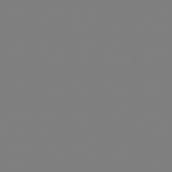

epoch: 0/300, batch: 10/600, G_loss: 0.687456488609314, D_loss: (0.5559504628181458, 0.6989263892173767)
epoch: 0/300, batch: 20/600, G_loss: 0.9186103343963623, D_loss: (0.4464058578014374, 0.5093110799789429)
epoch: 0/300, batch: 30/600, G_loss: 1.2700831890106201, D_loss: (0.2849937379360199, 0.32981938123703003)
epoch: 0/300, batch: 40/600, G_loss: 1.732497215270996, D_loss: (0.17281605303287506, 0.19550582766532898)
epoch: 0/300, batch: 50/600, G_loss: 2.0958592891693115, D_loss: (0.11341888457536697, 0.13163313269615173)
epoch: 0/300, batch: 60/600, G_loss: 2.4325084686279297, D_loss: (0.08517271280288696, 0.09219025820493698)
epoch: 0/300, batch: 70/600, G_loss: 2.8217673301696777, D_loss: (0.05586385726928711, 0.06187504157423973)
epoch: 0/300, batch: 80/600, G_loss: 3.0319008827209473, D_loss: (0.045073866844177246, 0.04996831715106964)
epoch: 0/300, batch: 90/600, G_loss: 3.247398614883423, D_loss: (0.03443479910492897, 0.041181255131959915)
epoch: 0/300, batch: 100/600, G_lo

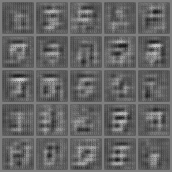

epoch: 0/300, batch: 110/600, G_loss: 3.650808811187744, D_loss: (0.025175612419843674, 0.026933398097753525)
epoch: 0/300, batch: 120/600, G_loss: 2.1965560913085938, D_loss: (1.9525967836380005, 0.13426904380321503)
epoch: 0/300, batch: 130/600, G_loss: 1.3616464138031006, D_loss: (0.5318925976753235, 0.31616705656051636)
epoch: 0/300, batch: 140/600, G_loss: 1.6968938112258911, D_loss: (0.20435477793216705, 0.24233435094356537)
epoch: 0/300, batch: 150/600, G_loss: 3.0110278129577637, D_loss: (0.18258194625377655, 0.05591078847646713)
epoch: 0/300, batch: 160/600, G_loss: 2.4731719493865967, D_loss: (0.07391736656427383, 0.1105930507183075)
epoch: 0/300, batch: 170/600, G_loss: 2.7400283813476562, D_loss: (0.060745421797037125, 0.08160736411809921)
epoch: 0/300, batch: 180/600, G_loss: 2.9750242233276367, D_loss: (0.043586574494838715, 0.059832800179719925)
epoch: 0/300, batch: 190/600, G_loss: 1.1344627141952515, D_loss: (0.38087132573127747, 0.44194865226745605)
epoch: 0/300, batc

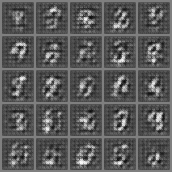

epoch: 0/300, batch: 210/600, G_loss: 0.23328694701194763, D_loss: (0.025123601779341698, 1.7713303565979004)
epoch: 0/300, batch: 220/600, G_loss: 2.3268866539001465, D_loss: (0.26197776198387146, 0.1272885650396347)
epoch: 0/300, batch: 230/600, G_loss: 0.43786200881004333, D_loss: (0.017173239961266518, 1.2525904178619385)
epoch: 0/300, batch: 240/600, G_loss: 1.0629364252090454, D_loss: (0.194040447473526, 0.6629505157470703)
epoch: 0/300, batch: 250/600, G_loss: 2.287471055984497, D_loss: (0.1327730268239975, 0.13376177847385406)
epoch: 0/300, batch: 260/600, G_loss: 2.7911388874053955, D_loss: (0.06922819465398788, 0.07108958810567856)
epoch: 0/300, batch: 270/600, G_loss: 1.1291614770889282, D_loss: (0.06649905443191528, 0.4305577576160431)
epoch: 0/300, batch: 280/600, G_loss: 4.135941028594971, D_loss: (1.503545880317688, 0.018408579751849174)
epoch: 0/300, batch: 290/600, G_loss: 2.460714817047119, D_loss: (0.11070242524147034, 0.10470516234636307)
epoch: 0/300, batch: 300/60

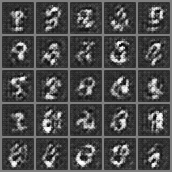

epoch: 0/300, batch: 310/600, G_loss: 3.8246634006500244, D_loss: (0.11215417832136154, 0.024667399004101753)
epoch: 0/300, batch: 320/600, G_loss: 3.8703839778900146, D_loss: (2.832571506500244, 0.024121958762407303)
epoch: 0/300, batch: 330/600, G_loss: 1.823960304260254, D_loss: (0.2347141057252884, 0.19886809587478638)
epoch: 0/300, batch: 340/600, G_loss: 2.1934139728546143, D_loss: (0.24160394072532654, 0.1349571794271469)
epoch: 0/300, batch: 350/600, G_loss: 3.4226861000061035, D_loss: (0.4075549244880676, 0.0385834276676178)
epoch: 0/300, batch: 360/600, G_loss: 1.9057940244674683, D_loss: (0.13293415307998657, 0.1857580691576004)
epoch: 0/300, batch: 370/600, G_loss: 2.1523351669311523, D_loss: (0.09259159862995148, 0.14409300684928894)
epoch: 0/300, batch: 380/600, G_loss: 3.6505255699157715, D_loss: (0.43753501772880554, 0.031059538945555687)
epoch: 0/300, batch: 390/600, G_loss: 2.407893419265747, D_loss: (0.1497439444065094, 0.11190425604581833)
epoch: 0/300, batch: 400/6

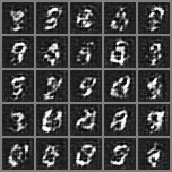

epoch: 0/300, batch: 410/600, G_loss: 4.375971794128418, D_loss: (0.39010679721832275, 0.014608610421419144)
epoch: 0/300, batch: 420/600, G_loss: 2.2833187580108643, D_loss: (0.32090553641319275, 0.11972632259130478)
epoch: 0/300, batch: 430/600, G_loss: 3.189171075820923, D_loss: (0.25620436668395996, 0.04933624714612961)
epoch: 0/300, batch: 440/600, G_loss: 2.548860549926758, D_loss: (0.10458659380674362, 0.10178770869970322)
epoch: 0/300, batch: 450/600, G_loss: 3.0826284885406494, D_loss: (0.0984005555510521, 0.05655888095498085)
epoch: 0/300, batch: 460/600, G_loss: 3.5446555614471436, D_loss: (0.11494534462690353, 0.03499402105808258)
epoch: 0/300, batch: 470/600, G_loss: 3.947904109954834, D_loss: (0.15891502797603607, 0.02420726791024208)
epoch: 0/300, batch: 480/600, G_loss: 0.6992251873016357, D_loss: (0.5045336484909058, 0.7710298895835876)
epoch: 0/300, batch: 490/600, G_loss: 2.169642925262451, D_loss: (0.8458609580993652, 0.14349043369293213)
epoch: 0/300, batch: 500/60

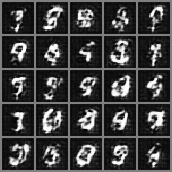

epoch: 0/300, batch: 510/600, G_loss: 1.1739012002944946, D_loss: (0.1223439946770668, 0.42231887578964233)
epoch: 0/300, batch: 520/600, G_loss: 3.0476737022399902, D_loss: (0.4484407305717468, 0.05500369146466255)
epoch: 0/300, batch: 530/600, G_loss: 2.7019662857055664, D_loss: (0.40823304653167725, 0.07838371396064758)
epoch: 0/300, batch: 540/600, G_loss: 1.8656622171401978, D_loss: (0.11299723386764526, 0.19210569560527802)
epoch: 0/300, batch: 550/600, G_loss: 2.4328250885009766, D_loss: (0.2059900313615799, 0.10901891440153122)
epoch: 0/300, batch: 560/600, G_loss: 2.233177423477173, D_loss: (0.16162538528442383, 0.1296663135290146)
epoch: 0/300, batch: 570/600, G_loss: 3.368788957595825, D_loss: (0.44326916337013245, 0.040476031601428986)
epoch: 0/300, batch: 580/600, G_loss: 3.022646903991699, D_loss: (0.8674877882003784, 0.059119123965501785)
epoch: 0/300, batch: 590/600, G_loss: 2.2298548221588135, D_loss: (0.09629672765731812, 0.14649558067321777)
epoch: 1/300, batch: 0/60

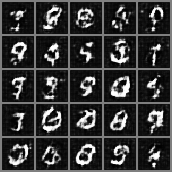

epoch: 1/300, batch: 10/600, G_loss: 3.1110925674438477, D_loss: (0.05782401189208031, 0.05752243101596832)
epoch: 1/300, batch: 20/600, G_loss: 1.2126574516296387, D_loss: (0.016380321234464645, 0.4126300513744354)
epoch: 1/300, batch: 30/600, G_loss: 0.996219277381897, D_loss: (0.2574690282344818, 0.5212610960006714)
epoch: 1/300, batch: 40/600, G_loss: 2.251377820968628, D_loss: (0.151709645986557, 0.13524675369262695)
epoch: 1/300, batch: 50/600, G_loss: 1.8825596570968628, D_loss: (0.11006630212068558, 0.19373048841953278)
epoch: 1/300, batch: 60/600, G_loss: 2.895108222961426, D_loss: (0.19556277990341187, 0.06963114440441132)
epoch: 1/300, batch: 70/600, G_loss: 2.6276309490203857, D_loss: (0.11244693398475647, 0.08855631202459335)
epoch: 1/300, batch: 80/600, G_loss: 2.625114679336548, D_loss: (0.055896539241075516, 0.08563889563083649)
epoch: 1/300, batch: 90/600, G_loss: 4.382695198059082, D_loss: (1.3273390531539917, 0.01715068705379963)
epoch: 1/300, batch: 100/600, G_loss:

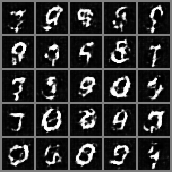

epoch: 1/300, batch: 110/600, G_loss: 2.921405076980591, D_loss: (0.15602552890777588, 0.07260692864656448)
epoch: 1/300, batch: 120/600, G_loss: 0.7381472587585449, D_loss: (0.01027150172740221, 0.7919677495956421)
epoch: 1/300, batch: 130/600, G_loss: 1.8404470682144165, D_loss: (0.3838597238063812, 0.22950440645217896)
epoch: 1/300, batch: 140/600, G_loss: 1.7834898233413696, D_loss: (0.15747448801994324, 0.22948209941387177)
epoch: 1/300, batch: 150/600, G_loss: 2.707773447036743, D_loss: (0.3731794059276581, 0.08273101598024368)
epoch: 1/300, batch: 160/600, G_loss: 1.2047111988067627, D_loss: (0.022709812968969345, 0.4346482753753662)
epoch: 1/300, batch: 170/600, G_loss: 0.7483784556388855, D_loss: (0.22881664335727692, 0.7768927216529846)
epoch: 1/300, batch: 180/600, G_loss: 1.4801080226898193, D_loss: (0.2971731424331665, 0.31097128987312317)
epoch: 1/300, batch: 190/600, G_loss: 1.532860517501831, D_loss: (0.11538089066743851, 0.306847482919693)
epoch: 1/300, batch: 200/600,

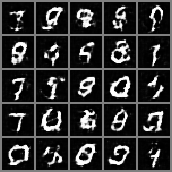

epoch: 1/300, batch: 210/600, G_loss: 1.9809592962265015, D_loss: (0.11679819971323013, 0.17237676680088043)
epoch: 1/300, batch: 220/600, G_loss: 0.6991775631904602, D_loss: (0.018528902903199196, 0.8086379766464233)
epoch: 1/300, batch: 230/600, G_loss: 1.4586312770843506, D_loss: (0.49882611632347107, 0.3094154894351959)
epoch: 1/300, batch: 240/600, G_loss: 2.067988157272339, D_loss: (0.20467418432235718, 0.1623578667640686)
epoch: 1/300, batch: 250/600, G_loss: 1.9820042848587036, D_loss: (0.16834288835525513, 0.18808387219905853)
epoch: 1/300, batch: 260/600, G_loss: 4.070593357086182, D_loss: (0.7832377552986145, 0.019922861829400063)
epoch: 1/300, batch: 270/600, G_loss: 2.0884368419647217, D_loss: (0.34070903062820435, 0.15998685359954834)
epoch: 1/300, batch: 280/600, G_loss: 2.845808982849121, D_loss: (0.4724619686603546, 0.08574124425649643)
epoch: 1/300, batch: 290/600, G_loss: 1.322763204574585, D_loss: (0.07103704661130905, 0.38640984892845154)
epoch: 1/300, batch: 300/6

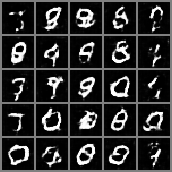

epoch: 1/300, batch: 310/600, G_loss: 1.743491768836975, D_loss: (0.22740165889263153, 0.22283613681793213)
epoch: 1/300, batch: 320/600, G_loss: 3.6104743480682373, D_loss: (0.5761752128601074, 0.03262721002101898)
epoch: 1/300, batch: 330/600, G_loss: 1.8658033609390259, D_loss: (0.08619055896997452, 0.2028014063835144)
epoch: 1/300, batch: 340/600, G_loss: 2.723475694656372, D_loss: (0.6364284753799438, 0.07906153053045273)
epoch: 1/300, batch: 350/600, G_loss: 2.300109624862671, D_loss: (0.5423312187194824, 0.13560190796852112)
epoch: 1/300, batch: 360/600, G_loss: 1.3263964653015137, D_loss: (0.18220065534114838, 0.3831232786178589)
epoch: 1/300, batch: 370/600, G_loss: 2.3773045539855957, D_loss: (0.22082528471946716, 0.11527375131845474)
epoch: 1/300, batch: 380/600, G_loss: 3.097867488861084, D_loss: (1.6351170539855957, 0.0576154887676239)
epoch: 1/300, batch: 390/600, G_loss: 1.2951538562774658, D_loss: (0.28967514634132385, 0.3733753561973572)
epoch: 1/300, batch: 400/600, G

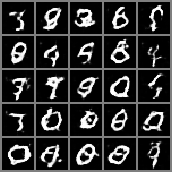

epoch: 1/300, batch: 410/600, G_loss: 1.8766849040985107, D_loss: (0.1573859453201294, 0.19654804468154907)
epoch: 1/300, batch: 420/600, G_loss: 1.0663821697235107, D_loss: (0.42792168259620667, 0.4750059247016907)
epoch: 1/300, batch: 430/600, G_loss: 2.295318603515625, D_loss: (0.6708115339279175, 0.13160282373428345)
epoch: 1/300, batch: 440/600, G_loss: 1.528009295463562, D_loss: (0.30285558104515076, 0.30312302708625793)
epoch: 1/300, batch: 450/600, G_loss: 2.0561270713806152, D_loss: (0.3790326416492462, 0.16000020503997803)
epoch: 1/300, batch: 460/600, G_loss: 0.26396244764328003, D_loss: (0.012990777380764484, 1.6164536476135254)
epoch: 1/300, batch: 470/600, G_loss: 1.544844388961792, D_loss: (0.25341978669166565, 0.2955085337162018)
epoch: 1/300, batch: 480/600, G_loss: 1.7476691007614136, D_loss: (0.2349337935447693, 0.22603516280651093)
epoch: 1/300, batch: 490/600, G_loss: 1.8885672092437744, D_loss: (0.2354811131954193, 0.19094891846179962)
epoch: 1/300, batch: 500/600

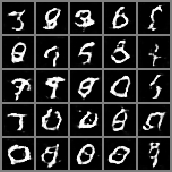

epoch: 1/300, batch: 510/600, G_loss: 1.6226348876953125, D_loss: (0.2383401095867157, 0.2563351094722748)
epoch: 1/300, batch: 520/600, G_loss: 0.40512803196907043, D_loss: (0.041756048798561096, 1.2642289400100708)
epoch: 1/300, batch: 530/600, G_loss: 1.2155671119689941, D_loss: (0.2575199604034424, 0.41938307881355286)
epoch: 1/300, batch: 540/600, G_loss: 1.6761459112167358, D_loss: (0.4102095067501068, 0.24025969207286835)
epoch: 1/300, batch: 550/600, G_loss: 2.2463040351867676, D_loss: (0.6472821831703186, 0.1308058500289917)
epoch: 1/300, batch: 560/600, G_loss: 0.7222396731376648, D_loss: (0.07848887145519257, 0.7733845710754395)
epoch: 1/300, batch: 570/600, G_loss: 1.1007640361785889, D_loss: (0.28456827998161316, 0.4782975912094116)
epoch: 1/300, batch: 580/600, G_loss: 2.2505462169647217, D_loss: (0.8511437773704529, 0.13683730363845825)
epoch: 1/300, batch: 590/600, G_loss: 1.9931998252868652, D_loss: (0.40726813673973083, 0.17334462702274323)
epoch: 2/300, batch: 0/600,

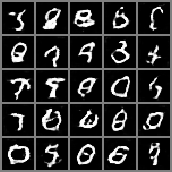

epoch: 2/300, batch: 10/600, G_loss: 4.353209972381592, D_loss: (1.7024785280227661, 0.01629067026078701)
epoch: 2/300, batch: 20/600, G_loss: 1.2240638732910156, D_loss: (0.3451066315174103, 0.4233176112174988)
epoch: 2/300, batch: 30/600, G_loss: 1.3480104207992554, D_loss: (0.2307615727186203, 0.35954493284225464)
epoch: 2/300, batch: 40/600, G_loss: 2.379718542098999, D_loss: (0.3485145568847656, 0.11737936735153198)
epoch: 2/300, batch: 50/600, G_loss: 2.3966193199157715, D_loss: (0.5456705689430237, 0.11550357937812805)
epoch: 2/300, batch: 60/600, G_loss: 1.6712292432785034, D_loss: (0.5339263677597046, 0.24650363624095917)
epoch: 2/300, batch: 70/600, G_loss: 0.638527512550354, D_loss: (0.09964492172002792, 0.8494775295257568)
epoch: 2/300, batch: 80/600, G_loss: 1.7450848817825317, D_loss: (0.2948493957519531, 0.23950929939746857)
epoch: 2/300, batch: 90/600, G_loss: 0.23185430467128754, D_loss: (0.027573416009545326, 1.7490440607070923)
epoch: 2/300, batch: 100/600, G_loss: 1

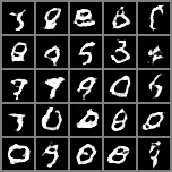

epoch: 2/300, batch: 110/600, G_loss: 2.6115386486053467, D_loss: (0.39131173491477966, 0.0929466038942337)
epoch: 2/300, batch: 120/600, G_loss: 1.434615135192871, D_loss: (0.2679041922092438, 0.3254290819168091)
epoch: 2/300, batch: 130/600, G_loss: 2.2622411251068115, D_loss: (1.0752785205841064, 0.1307736337184906)
epoch: 2/300, batch: 140/600, G_loss: 1.065101981163025, D_loss: (0.2148813009262085, 0.5035329461097717)
epoch: 2/300, batch: 150/600, G_loss: 1.2479764223098755, D_loss: (0.2406817227602005, 0.40486976504325867)
epoch: 2/300, batch: 160/600, G_loss: 1.171959638595581, D_loss: (0.175164133310318, 0.4388255774974823)
epoch: 2/300, batch: 170/600, G_loss: 1.4985774755477905, D_loss: (0.15438145399093628, 0.30187544226646423)
epoch: 2/300, batch: 180/600, G_loss: 1.3449863195419312, D_loss: (0.18559378385543823, 0.36255523562431335)
epoch: 2/300, batch: 190/600, G_loss: 2.267796516418457, D_loss: (0.30724310874938965, 0.13247421383857727)
epoch: 2/300, batch: 200/600, G_lo

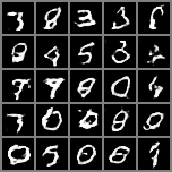

epoch: 2/300, batch: 210/600, G_loss: 1.520948886871338, D_loss: (0.4455123841762543, 0.2857012450695038)
epoch: 2/300, batch: 220/600, G_loss: 0.8625131249427795, D_loss: (0.11555970460176468, 0.6195774674415588)
epoch: 2/300, batch: 230/600, G_loss: 1.4846584796905518, D_loss: (0.20197433233261108, 0.3128613233566284)
epoch: 2/300, batch: 240/600, G_loss: 1.6066948175430298, D_loss: (0.26629000902175903, 0.26852816343307495)
epoch: 2/300, batch: 250/600, G_loss: 1.268288254737854, D_loss: (0.19999103248119354, 0.3941064774990082)
epoch: 2/300, batch: 260/600, G_loss: 1.5463000535964966, D_loss: (0.672773540019989, 0.27808523178100586)
epoch: 2/300, batch: 270/600, G_loss: 1.7543591260910034, D_loss: (0.6484140753746033, 0.2245275378227234)
epoch: 2/300, batch: 280/600, G_loss: 3.157801866531372, D_loss: (0.9672000408172607, 0.06499869376420975)
epoch: 2/300, batch: 290/600, G_loss: 1.4755654335021973, D_loss: (0.2772614359855652, 0.3130899965763092)
epoch: 2/300, batch: 300/600, G_lo

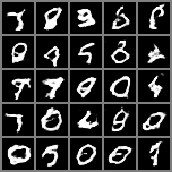

epoch: 2/300, batch: 310/600, G_loss: 0.6266562342643738, D_loss: (0.06069271266460419, 0.8946211934089661)
epoch: 2/300, batch: 320/600, G_loss: 3.739689826965332, D_loss: (1.626272439956665, 0.029203714802861214)
epoch: 2/300, batch: 330/600, G_loss: 1.738125205039978, D_loss: (0.4082336723804474, 0.23330263793468475)
epoch: 2/300, batch: 340/600, G_loss: 1.1835479736328125, D_loss: (0.13099412620067596, 0.4457705616950989)
epoch: 2/300, batch: 350/600, G_loss: 3.1817123889923096, D_loss: (0.7974810600280762, 0.05359908938407898)
epoch: 2/300, batch: 360/600, G_loss: 0.7609042525291443, D_loss: (0.06588134169578552, 0.7655143141746521)
epoch: 2/300, batch: 370/600, G_loss: 0.7714893817901611, D_loss: (0.33124932646751404, 0.717679500579834)
epoch: 2/300, batch: 380/600, G_loss: 2.266623020172119, D_loss: (0.7379761338233948, 0.1444818377494812)
epoch: 2/300, batch: 390/600, G_loss: 2.4360971450805664, D_loss: (0.5507305264472961, 0.12260320037603378)
epoch: 2/300, batch: 400/600, G_l

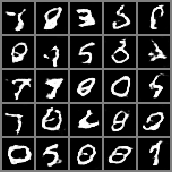

epoch: 2/300, batch: 410/600, G_loss: 2.9603271484375, D_loss: (0.7950629591941833, 0.06832146644592285)
epoch: 2/300, batch: 420/600, G_loss: 1.6856356859207153, D_loss: (0.1813911497592926, 0.2646538317203522)
epoch: 2/300, batch: 430/600, G_loss: 0.7700599431991577, D_loss: (0.3109421133995056, 0.7844339609146118)
epoch: 2/300, batch: 440/600, G_loss: 1.0690380334854126, D_loss: (0.4390069246292114, 0.4993727207183838)
epoch: 2/300, batch: 450/600, G_loss: 1.7237528562545776, D_loss: (0.41986504197120667, 0.24461466073989868)
epoch: 2/300, batch: 460/600, G_loss: 0.6074311137199402, D_loss: (0.16749677062034607, 0.9215675592422485)
epoch: 2/300, batch: 470/600, G_loss: 1.4706693887710571, D_loss: (0.31523653864860535, 0.34203851222991943)
epoch: 2/300, batch: 480/600, G_loss: 1.8081709146499634, D_loss: (0.4323192238807678, 0.22889380156993866)
epoch: 2/300, batch: 490/600, G_loss: 3.0813589096069336, D_loss: (1.0980805158615112, 0.06318983435630798)
epoch: 2/300, batch: 500/600, G_

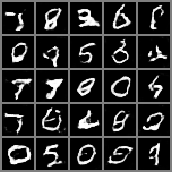

epoch: 2/300, batch: 510/600, G_loss: 1.252841830253601, D_loss: (0.1637212187051773, 0.414698988199234)
epoch: 2/300, batch: 520/600, G_loss: 0.9262064099311829, D_loss: (0.08922985941171646, 0.6473799347877502)
epoch: 2/300, batch: 530/600, G_loss: 2.3875138759613037, D_loss: (0.38968929648399353, 0.11536595225334167)
epoch: 2/300, batch: 540/600, G_loss: 1.6419992446899414, D_loss: (0.5073816180229187, 0.26495033502578735)
epoch: 2/300, batch: 550/600, G_loss: 1.0653769969940186, D_loss: (0.33162781596183777, 0.5178831219673157)
epoch: 2/300, batch: 560/600, G_loss: 1.146116852760315, D_loss: (0.28412672877311707, 0.44536152482032776)
epoch: 2/300, batch: 570/600, G_loss: 2.3158538341522217, D_loss: (0.725146472454071, 0.14717227220535278)
epoch: 2/300, batch: 580/600, G_loss: 2.5495309829711914, D_loss: (0.8082305788993835, 0.11476444453001022)
epoch: 2/300, batch: 590/600, G_loss: 1.6593624353408813, D_loss: (0.18470720946788788, 0.27034512162208557)
epoch: 3/300, batch: 0/600, G_

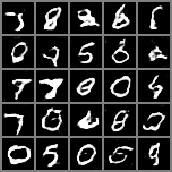

epoch: 3/300, batch: 10/600, G_loss: 0.5368342995643616, D_loss: (0.027724390849471092, 1.0569143295288086)
epoch: 3/300, batch: 20/600, G_loss: 1.4913314580917358, D_loss: (0.1828603744506836, 0.31298691034317017)
epoch: 3/300, batch: 30/600, G_loss: 4.098730087280273, D_loss: (1.3640928268432617, 0.029102178290486336)
epoch: 3/300, batch: 40/600, G_loss: 1.4993782043457031, D_loss: (0.19770967960357666, 0.3215108811855316)
epoch: 3/300, batch: 50/600, G_loss: 1.5373960733413696, D_loss: (0.22088375687599182, 0.3060770332813263)
epoch: 3/300, batch: 60/600, G_loss: 0.7053829431533813, D_loss: (0.03832566365599632, 0.8278660774230957)
epoch: 3/300, batch: 70/600, G_loss: 1.9723265171051025, D_loss: (0.3596472442150116, 0.20396237075328827)
epoch: 3/300, batch: 80/600, G_loss: 1.753259301185608, D_loss: (0.3949277997016907, 0.23818670213222504)
epoch: 3/300, batch: 90/600, G_loss: 2.491380214691162, D_loss: (0.22463619709014893, 0.11134590953588486)
epoch: 3/300, batch: 100/600, G_loss:

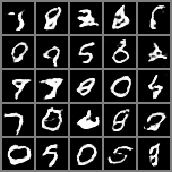

epoch: 3/300, batch: 110/600, G_loss: 1.684519648551941, D_loss: (0.1969931423664093, 0.256282240152359)
epoch: 3/300, batch: 120/600, G_loss: 0.9473299384117126, D_loss: (0.09932505339384079, 0.6123511791229248)
epoch: 3/300, batch: 130/600, G_loss: 3.246126651763916, D_loss: (1.548688530921936, 0.052568964660167694)
epoch: 3/300, batch: 140/600, G_loss: 2.2714974880218506, D_loss: (0.37659764289855957, 0.14754502475261688)
epoch: 3/300, batch: 150/600, G_loss: 1.7464910745620728, D_loss: (0.2688572108745575, 0.2544495761394501)
epoch: 3/300, batch: 160/600, G_loss: 1.0548983812332153, D_loss: (0.1636723130941391, 0.5541949272155762)
epoch: 3/300, batch: 170/600, G_loss: 2.2820847034454346, D_loss: (0.32430678606033325, 0.13323324918746948)
epoch: 3/300, batch: 180/600, G_loss: 2.693145513534546, D_loss: (0.43602633476257324, 0.09130693227052689)
epoch: 3/300, batch: 190/600, G_loss: 0.4128040373325348, D_loss: (0.03381454944610596, 1.2544914484024048)
epoch: 3/300, batch: 200/600, G_

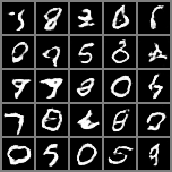

epoch: 3/300, batch: 210/600, G_loss: 2.0989456176757812, D_loss: (0.37454670667648315, 0.1701720803976059)
epoch: 3/300, batch: 220/600, G_loss: 2.3624799251556396, D_loss: (0.5669429302215576, 0.12003389000892639)
epoch: 3/300, batch: 230/600, G_loss: 0.6020126938819885, D_loss: (0.0850062444806099, 0.9991238117218018)
epoch: 3/300, batch: 240/600, G_loss: 1.6742764711380005, D_loss: (0.6568244099617004, 0.24163000285625458)
epoch: 3/300, batch: 250/600, G_loss: 1.8316682577133179, D_loss: (0.5543943643569946, 0.22616510093212128)
epoch: 3/300, batch: 260/600, G_loss: 3.143204689025879, D_loss: (1.3298035860061646, 0.06207872927188873)
epoch: 3/300, batch: 270/600, G_loss: 1.1588550806045532, D_loss: (0.2391757220029831, 0.5323391556739807)
epoch: 3/300, batch: 280/600, G_loss: 1.1171865463256836, D_loss: (0.09190044552087784, 0.5074417591094971)
epoch: 3/300, batch: 290/600, G_loss: 1.699954628944397, D_loss: (0.3133418560028076, 0.2761904001235962)
epoch: 3/300, batch: 300/600, G_l

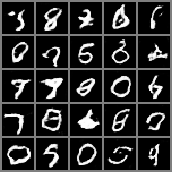

epoch: 3/300, batch: 310/600, G_loss: 2.505087375640869, D_loss: (0.5549658536911011, 0.1105019673705101)
epoch: 3/300, batch: 320/600, G_loss: 2.027539014816284, D_loss: (0.20880664885044098, 0.18741817772388458)
epoch: 3/300, batch: 330/600, G_loss: 3.37802791595459, D_loss: (1.0960626602172852, 0.04451333358883858)
epoch: 3/300, batch: 340/600, G_loss: 2.5989017486572266, D_loss: (0.6209853291511536, 0.11025046557188034)
epoch: 3/300, batch: 350/600, G_loss: 1.9764825105667114, D_loss: (0.25382116436958313, 0.18672457337379456)
epoch: 3/300, batch: 360/600, G_loss: 2.1645333766937256, D_loss: (0.5973700881004333, 0.1515323519706726)
epoch: 3/300, batch: 370/600, G_loss: 1.8508015871047974, D_loss: (0.22641412913799286, 0.2396884560585022)
epoch: 3/300, batch: 380/600, G_loss: 2.3380231857299805, D_loss: (0.5104203820228577, 0.14273838698863983)
epoch: 3/300, batch: 390/600, G_loss: 0.31659451127052307, D_loss: (0.01661314070224762, 1.5514402389526367)
epoch: 3/300, batch: 400/600, G

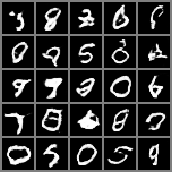

epoch: 3/300, batch: 410/600, G_loss: 2.328266143798828, D_loss: (0.47945958375930786, 0.13025541603565216)
epoch: 3/300, batch: 420/600, G_loss: 0.9834063053131104, D_loss: (0.0791807472705841, 0.5844415426254272)
epoch: 3/300, batch: 430/600, G_loss: 4.284816741943359, D_loss: (1.2076315879821777, 0.019421495497226715)
epoch: 3/300, batch: 440/600, G_loss: 0.7176505327224731, D_loss: (0.07886620610952377, 0.8821671009063721)
epoch: 3/300, batch: 450/600, G_loss: 1.3151898384094238, D_loss: (0.23657113313674927, 0.39932486414909363)
epoch: 3/300, batch: 460/600, G_loss: 1.2277157306671143, D_loss: (0.1481064409017563, 0.4909566640853882)
epoch: 3/300, batch: 470/600, G_loss: 1.6664345264434814, D_loss: (0.2121538668870926, 0.28276267647743225)
epoch: 3/300, batch: 480/600, G_loss: 1.6668782234191895, D_loss: (0.2277093529701233, 0.2807740867137909)
epoch: 3/300, batch: 490/600, G_loss: 0.6917943358421326, D_loss: (0.061999257653951645, 0.9109183549880981)
epoch: 3/300, batch: 500/600,

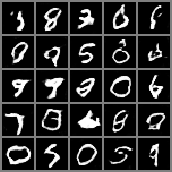

epoch: 3/300, batch: 510/600, G_loss: 1.9826138019561768, D_loss: (0.2561890184879303, 0.20451468229293823)
epoch: 3/300, batch: 520/600, G_loss: 1.4915302991867065, D_loss: (0.2652915418148041, 0.3322681486606598)
epoch: 3/300, batch: 530/600, G_loss: 2.6551260948181152, D_loss: (0.8697077035903931, 0.10277768224477768)
epoch: 3/300, batch: 540/600, G_loss: 0.26090821623802185, D_loss: (0.026009714230895042, 1.712295413017273)
epoch: 3/300, batch: 550/600, G_loss: 2.401095390319824, D_loss: (0.29688334465026855, 0.1310614049434662)
epoch: 3/300, batch: 560/600, G_loss: 1.9481960535049438, D_loss: (0.34480708837509155, 0.2083635777235031)
epoch: 3/300, batch: 570/600, G_loss: 1.1458390951156616, D_loss: (0.10113483667373657, 0.5110777020454407)
epoch: 3/300, batch: 580/600, G_loss: 2.058213710784912, D_loss: (0.4695843458175659, 0.18896843492984772)
epoch: 3/300, batch: 590/600, G_loss: 1.0831316709518433, D_loss: (0.11717425286769867, 0.5671542882919312)
epoch: 4/300, batch: 0/600, G_

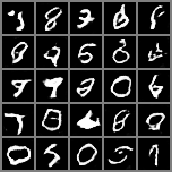

epoch: 4/300, batch: 10/600, G_loss: 2.5780467987060547, D_loss: (0.5071284770965576, 0.1220848485827446)
epoch: 4/300, batch: 20/600, G_loss: 1.8509657382965088, D_loss: (0.14218787848949432, 0.2305215448141098)
epoch: 4/300, batch: 30/600, G_loss: 1.5917441844940186, D_loss: (0.18607956171035767, 0.317776620388031)
epoch: 4/300, batch: 40/600, G_loss: 2.1954236030578613, D_loss: (0.37692296504974365, 0.16247588396072388)
epoch: 4/300, batch: 50/600, G_loss: 3.4686167240142822, D_loss: (1.869462013244629, 0.04720237851142883)
epoch: 4/300, batch: 60/600, G_loss: 1.5610216856002808, D_loss: (0.6409251689910889, 0.3018883764743805)
epoch: 4/300, batch: 70/600, G_loss: 2.120551109313965, D_loss: (0.5017400979995728, 0.1684572398662567)
epoch: 4/300, batch: 80/600, G_loss: 2.0322840213775635, D_loss: (0.36881911754608154, 0.21153554320335388)
epoch: 4/300, batch: 90/600, G_loss: 1.8183108568191528, D_loss: (0.19293463230133057, 0.24493667483329773)
epoch: 4/300, batch: 100/600, G_loss: 1.

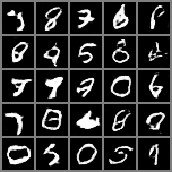

epoch: 4/300, batch: 110/600, G_loss: 1.2316755056381226, D_loss: (0.2227572500705719, 0.4569361209869385)
epoch: 4/300, batch: 120/600, G_loss: 0.7649728655815125, D_loss: (0.0668954849243164, 0.8498660326004028)
epoch: 4/300, batch: 130/600, G_loss: 0.5115915536880493, D_loss: (0.048904672265052795, 1.1332080364227295)
epoch: 4/300, batch: 140/600, G_loss: 1.4298161268234253, D_loss: (0.1993066817522049, 0.3531245291233063)
epoch: 4/300, batch: 150/600, G_loss: 0.8016396164894104, D_loss: (0.16037768125534058, 0.7150512933731079)
epoch: 4/300, batch: 160/600, G_loss: 2.197369337081909, D_loss: (0.3741799592971802, 0.17439374327659607)
epoch: 4/300, batch: 170/600, G_loss: 0.4366941452026367, D_loss: (0.03293076157569885, 1.5039409399032593)
epoch: 4/300, batch: 180/600, G_loss: 2.0924642086029053, D_loss: (0.37715861201286316, 0.18567140400409698)
epoch: 4/300, batch: 190/600, G_loss: 0.8577994704246521, D_loss: (0.14467093348503113, 0.7074156403541565)
epoch: 4/300, batch: 200/600, 

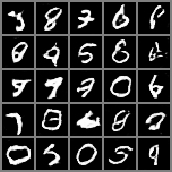

epoch: 4/300, batch: 210/600, G_loss: 2.6948602199554443, D_loss: (0.4096769094467163, 0.11230765283107758)
epoch: 4/300, batch: 220/600, G_loss: 2.6232404708862305, D_loss: (0.40438225865364075, 0.11076757311820984)
epoch: 4/300, batch: 230/600, G_loss: 2.152616500854492, D_loss: (0.3097132742404938, 0.17666518688201904)
epoch: 4/300, batch: 240/600, G_loss: 2.343789577484131, D_loss: (0.6436683535575867, 0.13458512723445892)
epoch: 4/300, batch: 250/600, G_loss: 1.2424602508544922, D_loss: (0.15015719830989838, 0.44713470339775085)
epoch: 4/300, batch: 260/600, G_loss: 2.253267765045166, D_loss: (0.367660254240036, 0.15467624366283417)
epoch: 4/300, batch: 270/600, G_loss: 1.343770146369934, D_loss: (0.1612241119146347, 0.44434285163879395)
epoch: 4/300, batch: 280/600, G_loss: 1.569203495979309, D_loss: (0.3244771957397461, 0.3237427771091461)
epoch: 4/300, batch: 290/600, G_loss: 0.3068767786026001, D_loss: (0.023740870878100395, 1.606679081916809)
epoch: 4/300, batch: 300/600, G_l

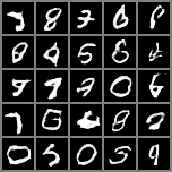

epoch: 4/300, batch: 310/600, G_loss: 0.7723982334136963, D_loss: (0.07917086780071259, 0.8523404598236084)
epoch: 4/300, batch: 320/600, G_loss: 1.6769464015960693, D_loss: (0.1747034639120102, 0.2842581868171692)
epoch: 4/300, batch: 330/600, G_loss: 1.7771676778793335, D_loss: (0.2275203913450241, 0.2572171688079834)
epoch: 4/300, batch: 340/600, G_loss: 3.922981023788452, D_loss: (1.5219323635101318, 0.030309250578284264)
epoch: 4/300, batch: 350/600, G_loss: 1.3139408826828003, D_loss: (0.19025027751922607, 0.4083724915981293)
epoch: 4/300, batch: 360/600, G_loss: 2.7293033599853516, D_loss: (0.5300344228744507, 0.09579887986183167)
epoch: 4/300, batch: 370/600, G_loss: 1.7707232236862183, D_loss: (0.21817471086978912, 0.2436686009168625)
epoch: 4/300, batch: 380/600, G_loss: 1.3271780014038086, D_loss: (0.2172868400812149, 0.4015790522098541)
epoch: 4/300, batch: 390/600, G_loss: 0.9040004014968872, D_loss: (0.10323050618171692, 0.6862319707870483)
epoch: 4/300, batch: 400/600, G

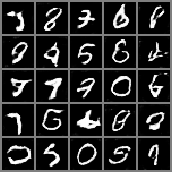

epoch: 4/300, batch: 410/600, G_loss: 1.8169916868209839, D_loss: (0.21528980135917664, 0.2419263869524002)
epoch: 4/300, batch: 420/600, G_loss: 0.567605197429657, D_loss: (0.10288142412900925, 1.0724557638168335)
epoch: 4/300, batch: 430/600, G_loss: 1.9636714458465576, D_loss: (0.6320072412490845, 0.19780370593070984)
epoch: 4/300, batch: 440/600, G_loss: 1.3633368015289307, D_loss: (0.35136544704437256, 0.38338541984558105)
epoch: 4/300, batch: 450/600, G_loss: 1.6286442279815674, D_loss: (0.29534968733787537, 0.31790339946746826)
epoch: 4/300, batch: 460/600, G_loss: 1.1506309509277344, D_loss: (0.16632452607154846, 0.5075762867927551)
epoch: 4/300, batch: 470/600, G_loss: 3.2728521823883057, D_loss: (0.7326480150222778, 0.05702672153711319)
epoch: 4/300, batch: 480/600, G_loss: 1.4637269973754883, D_loss: (0.37301933765411377, 0.37559977173805237)
epoch: 4/300, batch: 490/600, G_loss: 1.2864346504211426, D_loss: (0.15824533998966217, 0.4779699742794037)
epoch: 4/300, batch: 500/6

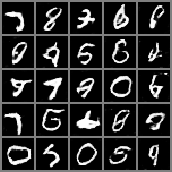

epoch: 4/300, batch: 510/600, G_loss: 1.7718929052352905, D_loss: (0.2027120143175125, 0.25555211305618286)
epoch: 4/300, batch: 520/600, G_loss: 1.1496858596801758, D_loss: (0.21907097101211548, 0.5079173445701599)
epoch: 4/300, batch: 530/600, G_loss: 2.72342586517334, D_loss: (0.43928512930870056, 0.10812839865684509)
epoch: 4/300, batch: 540/600, G_loss: 2.086270809173584, D_loss: (0.25662705302238464, 0.19971266388893127)
epoch: 4/300, batch: 550/600, G_loss: 1.4580392837524414, D_loss: (0.23699353635311127, 0.37877991795539856)
epoch: 4/300, batch: 560/600, G_loss: 1.582566499710083, D_loss: (0.27809247374534607, 0.3034674823284149)
epoch: 4/300, batch: 570/600, G_loss: 3.650956153869629, D_loss: (0.9364162683486938, 0.03936069458723068)
epoch: 4/300, batch: 580/600, G_loss: 2.5164055824279785, D_loss: (0.8282566070556641, 0.11706498265266418)
epoch: 4/300, batch: 590/600, G_loss: 3.1319305896759033, D_loss: (0.6566954255104065, 0.0611063577234745)
epoch: 5/300, batch: 0/600, G_l

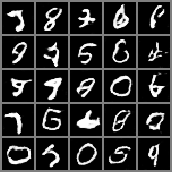

epoch: 5/300, batch: 10/600, G_loss: 2.4215641021728516, D_loss: (0.4981400966644287, 0.1416349560022354)
epoch: 5/300, batch: 20/600, G_loss: 1.4347083568572998, D_loss: (0.17685145139694214, 0.3934769034385681)
epoch: 5/300, batch: 30/600, G_loss: 1.4209612607955933, D_loss: (0.1287384033203125, 0.408740758895874)
epoch: 5/300, batch: 40/600, G_loss: 3.1547396183013916, D_loss: (0.7541018128395081, 0.07063790410757065)
epoch: 5/300, batch: 50/600, G_loss: 3.754462480545044, D_loss: (0.856595516204834, 0.03824726864695549)
epoch: 5/300, batch: 60/600, G_loss: 0.3174024522304535, D_loss: (0.03951624780893326, 1.6215646266937256)
epoch: 5/300, batch: 70/600, G_loss: 2.372246503829956, D_loss: (0.7123196125030518, 0.1382102072238922)
epoch: 5/300, batch: 80/600, G_loss: 1.5983749628067017, D_loss: (0.1505315899848938, 0.32846057415008545)
epoch: 5/300, batch: 90/600, G_loss: 3.509417772293091, D_loss: (0.8137075304985046, 0.04423775523900986)
epoch: 5/300, batch: 100/600, G_loss: 1.12306

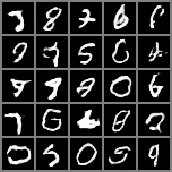

epoch: 5/300, batch: 110/600, G_loss: 2.2605767250061035, D_loss: (0.5166581273078918, 0.15078668296337128)
epoch: 5/300, batch: 120/600, G_loss: 1.5354152917861938, D_loss: (0.3793298304080963, 0.3353300988674164)
epoch: 5/300, batch: 130/600, G_loss: 1.8192673921585083, D_loss: (0.3004196286201477, 0.23229652643203735)
epoch: 5/300, batch: 140/600, G_loss: 1.3762898445129395, D_loss: (0.22231823205947876, 0.40780022740364075)
epoch: 5/300, batch: 150/600, G_loss: 1.9297503232955933, D_loss: (0.22473196685314178, 0.23756219446659088)
epoch: 5/300, batch: 160/600, G_loss: 2.0832161903381348, D_loss: (0.2632107734680176, 0.18603183329105377)
epoch: 5/300, batch: 170/600, G_loss: 0.7306073904037476, D_loss: (0.05872945860028267, 0.8855985999107361)
epoch: 5/300, batch: 180/600, G_loss: 1.1626784801483154, D_loss: (0.09429971873760223, 0.5029624700546265)
epoch: 5/300, batch: 190/600, G_loss: 2.4945921897888184, D_loss: (0.2857479155063629, 0.12318509817123413)
epoch: 5/300, batch: 200/60

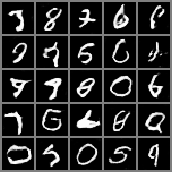

epoch: 5/300, batch: 210/600, G_loss: 2.112919330596924, D_loss: (0.27701279520988464, 0.19712626934051514)
epoch: 5/300, batch: 220/600, G_loss: 2.0614209175109863, D_loss: (0.2317453771829605, 0.20697006583213806)
epoch: 5/300, batch: 230/600, G_loss: 1.0037199258804321, D_loss: (0.052560463547706604, 0.6254462599754333)
epoch: 5/300, batch: 240/600, G_loss: 3.2493209838867188, D_loss: (0.6150855422019958, 0.06714212894439697)
epoch: 5/300, batch: 250/600, G_loss: 2.1390340328216553, D_loss: (0.139541894197464, 0.20280879735946655)
epoch: 5/300, batch: 260/600, G_loss: 1.662197232246399, D_loss: (0.6767500042915344, 0.29271256923675537)
epoch: 5/300, batch: 270/600, G_loss: 1.2093396186828613, D_loss: (0.5014662742614746, 0.5012692213058472)
epoch: 5/300, batch: 280/600, G_loss: 1.2603998184204102, D_loss: (0.6697876453399658, 0.4456091821193695)
epoch: 5/300, batch: 290/600, G_loss: 1.4797688722610474, D_loss: (0.42564597725868225, 0.32380732893943787)
epoch: 5/300, batch: 300/600, 

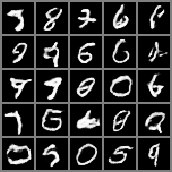

epoch: 5/300, batch: 310/600, G_loss: 2.1685707569122314, D_loss: (0.45603829622268677, 0.1669788807630539)
epoch: 5/300, batch: 320/600, G_loss: 1.7371695041656494, D_loss: (0.44249606132507324, 0.28864824771881104)
epoch: 5/300, batch: 330/600, G_loss: 1.7466257810592651, D_loss: (0.43327248096466064, 0.29177626967430115)
epoch: 5/300, batch: 340/600, G_loss: 0.9342833757400513, D_loss: (0.13365890085697174, 0.7895738482475281)
epoch: 5/300, batch: 350/600, G_loss: 1.5281436443328857, D_loss: (0.6024108529090881, 0.35951340198516846)
epoch: 5/300, batch: 360/600, G_loss: 2.605959177017212, D_loss: (0.5485657453536987, 0.11856204271316528)
epoch: 5/300, batch: 370/600, G_loss: 3.0544345378875732, D_loss: (1.376349925994873, 0.08503550291061401)
epoch: 5/300, batch: 380/600, G_loss: 1.2634369134902954, D_loss: (0.31184396147727966, 0.4572741985321045)
epoch: 5/300, batch: 390/600, G_loss: 1.9609318971633911, D_loss: (0.27018532156944275, 0.22551850974559784)
epoch: 5/300, batch: 400/60

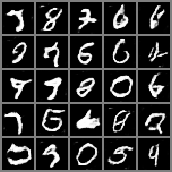

epoch: 5/300, batch: 410/600, G_loss: 1.380193829536438, D_loss: (0.2963945269584656, 0.3993934392929077)
epoch: 5/300, batch: 420/600, G_loss: 2.1645519733428955, D_loss: (0.8979061245918274, 0.17178574204444885)
epoch: 5/300, batch: 430/600, G_loss: 1.5118376016616821, D_loss: (0.2752780616283417, 0.34803542494773865)
epoch: 5/300, batch: 440/600, G_loss: 1.453267216682434, D_loss: (0.172308087348938, 0.36528462171554565)
epoch: 5/300, batch: 450/600, G_loss: 1.3574509620666504, D_loss: (0.14278727769851685, 0.4350273907184601)
epoch: 5/300, batch: 460/600, G_loss: 0.9268125295639038, D_loss: (0.16453592479228973, 0.6936522126197815)
epoch: 5/300, batch: 470/600, G_loss: 1.1315484046936035, D_loss: (0.10007273405790329, 0.545833945274353)
epoch: 5/300, batch: 480/600, G_loss: 1.6007628440856934, D_loss: (0.17354223132133484, 0.35829854011535645)
epoch: 5/300, batch: 490/600, G_loss: 1.862999439239502, D_loss: (0.32990798354148865, 0.24613794684410095)
epoch: 5/300, batch: 500/600, G_

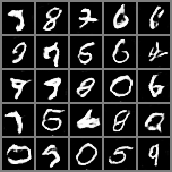

epoch: 5/300, batch: 510/600, G_loss: 1.9003382921218872, D_loss: (0.5813658237457275, 0.2094649374485016)
epoch: 5/300, batch: 520/600, G_loss: 2.121246814727783, D_loss: (0.4049614667892456, 0.19200514256954193)
epoch: 5/300, batch: 530/600, G_loss: 2.076197862625122, D_loss: (0.36150240898132324, 0.20071786642074585)
epoch: 5/300, batch: 540/600, G_loss: 1.9850419759750366, D_loss: (0.7403988838195801, 0.22230394184589386)
epoch: 5/300, batch: 550/600, G_loss: 1.1569006443023682, D_loss: (0.2891097962856293, 0.4680456221103668)
epoch: 5/300, batch: 560/600, G_loss: 1.4249296188354492, D_loss: (0.12518638372421265, 0.3669104278087616)
epoch: 5/300, batch: 570/600, G_loss: 2.8114469051361084, D_loss: (0.5632255673408508, 0.0849098190665245)
epoch: 5/300, batch: 580/600, G_loss: 2.335346221923828, D_loss: (0.46703776717185974, 0.13912039995193481)
epoch: 5/300, batch: 590/600, G_loss: 1.9004426002502441, D_loss: (0.40847426652908325, 0.21231459081172943)
epoch: 6/300, batch: 0/600, G_l

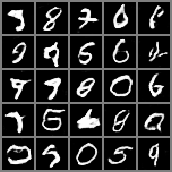

epoch: 6/300, batch: 10/600, G_loss: 0.5576364398002625, D_loss: (0.060687724500894547, 1.060147762298584)
epoch: 6/300, batch: 20/600, G_loss: 0.9141542911529541, D_loss: (0.09852822124958038, 0.6855201721191406)
epoch: 6/300, batch: 30/600, G_loss: 1.7289108037948608, D_loss: (0.2311648577451706, 0.26666194200515747)
epoch: 6/300, batch: 40/600, G_loss: 1.1536146402359009, D_loss: (0.19679422676563263, 0.4909556210041046)
epoch: 6/300, batch: 50/600, G_loss: 0.468837708234787, D_loss: (0.027704467996954918, 1.3974586725234985)
epoch: 6/300, batch: 60/600, G_loss: 1.539685845375061, D_loss: (0.26438677310943604, 0.3305737376213074)
epoch: 6/300, batch: 70/600, G_loss: 0.8905454277992249, D_loss: (0.09983623772859573, 0.7330257892608643)
epoch: 6/300, batch: 80/600, G_loss: 2.1890335083007812, D_loss: (0.4366670548915863, 0.1819780021905899)
epoch: 6/300, batch: 90/600, G_loss: 2.346627712249756, D_loss: (0.27671241760253906, 0.13977457582950592)
epoch: 6/300, batch: 100/600, G_loss: 1

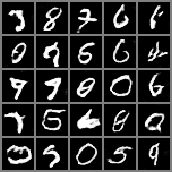

epoch: 6/300, batch: 110/600, G_loss: 1.6709805727005005, D_loss: (0.16717350482940674, 0.271789014339447)
epoch: 6/300, batch: 120/600, G_loss: 1.0691101551055908, D_loss: (0.08222682029008865, 0.534824550151825)
epoch: 6/300, batch: 130/600, G_loss: 1.1303809881210327, D_loss: (0.12298352271318436, 0.5310552716255188)
epoch: 6/300, batch: 140/600, G_loss: 1.6028307676315308, D_loss: (0.2500547170639038, 0.3140333890914917)
epoch: 6/300, batch: 150/600, G_loss: 1.054850697517395, D_loss: (0.11743365973234177, 0.5681060552597046)
epoch: 6/300, batch: 160/600, G_loss: 2.5094432830810547, D_loss: (0.48000407218933105, 0.1231498271226883)
epoch: 6/300, batch: 170/600, G_loss: 1.7119251489639282, D_loss: (0.23777902126312256, 0.2783806622028351)
epoch: 6/300, batch: 180/600, G_loss: 1.871388554573059, D_loss: (0.5447846055030823, 0.23279647529125214)
epoch: 6/300, batch: 190/600, G_loss: 1.120375156402588, D_loss: (0.3834930658340454, 0.5415647625923157)
epoch: 6/300, batch: 200/600, G_los

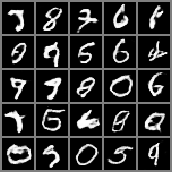

epoch: 6/300, batch: 210/600, G_loss: 1.6066980361938477, D_loss: (0.27118611335754395, 0.32122862339019775)
epoch: 6/300, batch: 220/600, G_loss: 1.9002848863601685, D_loss: (0.4507330656051636, 0.25283172726631165)
epoch: 6/300, batch: 230/600, G_loss: 1.6669315099716187, D_loss: (0.232574924826622, 0.2632226049900055)
epoch: 6/300, batch: 240/600, G_loss: 0.8960846662521362, D_loss: (0.0981357991695404, 0.716830313205719)
epoch: 6/300, batch: 250/600, G_loss: 1.4234617948532104, D_loss: (0.15331177413463593, 0.3631860315799713)
epoch: 6/300, batch: 260/600, G_loss: 1.3333957195281982, D_loss: (0.21267585456371307, 0.4454843997955322)
epoch: 6/300, batch: 270/600, G_loss: 2.958836078643799, D_loss: (0.5583395957946777, 0.0713842511177063)
epoch: 6/300, batch: 280/600, G_loss: 1.5572421550750732, D_loss: (0.17731693387031555, 0.35140591859817505)
epoch: 6/300, batch: 290/600, G_loss: 2.203165054321289, D_loss: (0.3244630694389343, 0.17697042226791382)
epoch: 6/300, batch: 300/600, G_l

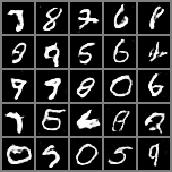

epoch: 6/300, batch: 310/600, G_loss: 2.2253670692443848, D_loss: (0.46860572695732117, 0.15943953394889832)
epoch: 6/300, batch: 320/600, G_loss: 1.3351826667785645, D_loss: (0.19976145029067993, 0.4012601375579834)
epoch: 6/300, batch: 330/600, G_loss: 0.9938256144523621, D_loss: (0.043967653065919876, 0.6415020227432251)
epoch: 6/300, batch: 340/600, G_loss: 1.3421248197555542, D_loss: (0.09426712244749069, 0.4663061797618866)
epoch: 6/300, batch: 350/600, G_loss: 2.15390944480896, D_loss: (0.3709293305873871, 0.1732001155614853)
epoch: 6/300, batch: 360/600, G_loss: 2.330519676208496, D_loss: (0.5005638599395752, 0.15327505767345428)
epoch: 6/300, batch: 370/600, G_loss: 2.329671621322632, D_loss: (0.2580846846103668, 0.1451173573732376)
epoch: 6/300, batch: 380/600, G_loss: 1.4444169998168945, D_loss: (0.27501097321510315, 0.36039188504219055)
epoch: 6/300, batch: 390/600, G_loss: 1.4871532917022705, D_loss: (0.1926828771829605, 0.3789491653442383)
epoch: 6/300, batch: 400/600, G_

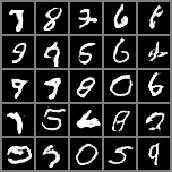

epoch: 6/300, batch: 410/600, G_loss: 0.3906930088996887, D_loss: (0.029047619551420212, 1.4374322891235352)
epoch: 6/300, batch: 420/600, G_loss: 2.1662356853485107, D_loss: (0.4027819335460663, 0.17442119121551514)
epoch: 6/300, batch: 430/600, G_loss: 1.551231026649475, D_loss: (0.22723069787025452, 0.3385201692581177)
epoch: 6/300, batch: 440/600, G_loss: 1.797563910484314, D_loss: (0.21667852997779846, 0.270514577627182)
epoch: 6/300, batch: 450/600, G_loss: 1.6170146465301514, D_loss: (0.17131920158863068, 0.3208386301994324)
epoch: 6/300, batch: 460/600, G_loss: 1.7046186923980713, D_loss: (0.30048641562461853, 0.26156461238861084)
epoch: 6/300, batch: 470/600, G_loss: 2.9336304664611816, D_loss: (0.39886268973350525, 0.0904460921883583)
epoch: 6/300, batch: 480/600, G_loss: 0.6624851226806641, D_loss: (0.04332048445940018, 0.9344825148582458)
epoch: 6/300, batch: 490/600, G_loss: 0.4213883578777313, D_loss: (0.03890605270862579, 1.3959224224090576)
epoch: 6/300, batch: 500/600,

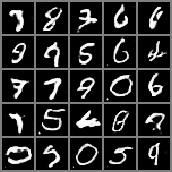

epoch: 6/300, batch: 510/600, G_loss: 1.1602708101272583, D_loss: (0.148111954331398, 0.4939046800136566)
epoch: 6/300, batch: 520/600, G_loss: 1.2176768779754639, D_loss: (0.16900750994682312, 0.48965850472450256)
epoch: 6/300, batch: 530/600, G_loss: 1.6828137636184692, D_loss: (0.23941271007061005, 0.3032066822052002)
epoch: 6/300, batch: 540/600, G_loss: 1.326370120048523, D_loss: (0.17270584404468536, 0.4077124297618866)
epoch: 6/300, batch: 550/600, G_loss: 2.3447153568267822, D_loss: (0.6215752363204956, 0.1661718338727951)
epoch: 6/300, batch: 560/600, G_loss: 0.49694862961769104, D_loss: (0.06034819781780243, 1.2556990385055542)
epoch: 6/300, batch: 570/600, G_loss: 2.7154085636138916, D_loss: (0.8462077975273132, 0.11212079226970673)
epoch: 6/300, batch: 580/600, G_loss: 2.330930233001709, D_loss: (0.42175593972206116, 0.14152739942073822)
epoch: 6/300, batch: 590/600, G_loss: 0.8084394335746765, D_loss: (0.04790392518043518, 0.7707604765892029)
epoch: 7/300, batch: 0/600, G_

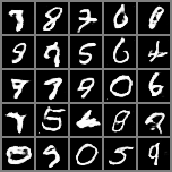

epoch: 7/300, batch: 10/600, G_loss: 4.649721145629883, D_loss: (1.3225717544555664, 0.02552136965095997)
epoch: 7/300, batch: 20/600, G_loss: 1.0187668800354004, D_loss: (0.09394536912441254, 0.6229985952377319)
epoch: 7/300, batch: 30/600, G_loss: 2.928060293197632, D_loss: (0.5079332590103149, 0.09919466078281403)
epoch: 7/300, batch: 40/600, G_loss: 1.7376012802124023, D_loss: (0.20265628397464752, 0.3138466477394104)
epoch: 7/300, batch: 50/600, G_loss: 1.878173828125, D_loss: (0.22604547441005707, 0.23389531672000885)
epoch: 7/300, batch: 60/600, G_loss: 2.034494638442993, D_loss: (0.2440974861383438, 0.2082449346780777)
epoch: 7/300, batch: 70/600, G_loss: 1.6018333435058594, D_loss: (0.49985045194625854, 0.32568514347076416)
epoch: 7/300, batch: 80/600, G_loss: 1.7321951389312744, D_loss: (0.15316830575466156, 0.30844563245773315)
epoch: 7/300, batch: 90/600, G_loss: 1.3769540786743164, D_loss: (0.2645859718322754, 0.3888290524482727)
epoch: 7/300, batch: 100/600, G_loss: 0.394

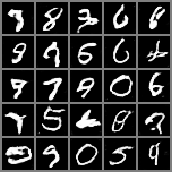

epoch: 7/300, batch: 110/600, G_loss: 1.980806589126587, D_loss: (0.31882786750793457, 0.21837127208709717)
epoch: 7/300, batch: 120/600, G_loss: 1.8212623596191406, D_loss: (0.201033815741539, 0.2667433023452759)
epoch: 7/300, batch: 130/600, G_loss: 1.6207586526870728, D_loss: (0.16727033257484436, 0.3443487882614136)
epoch: 7/300, batch: 140/600, G_loss: 0.9276662468910217, D_loss: (0.07291550189256668, 0.6484284996986389)
epoch: 7/300, batch: 150/600, G_loss: 2.9088680744171143, D_loss: (0.39689522981643677, 0.08774775266647339)
epoch: 7/300, batch: 160/600, G_loss: 2.3736460208892822, D_loss: (0.5023259520530701, 0.155319944024086)
epoch: 7/300, batch: 170/600, G_loss: 3.466622829437256, D_loss: (1.0210418701171875, 0.0498516745865345)
epoch: 7/300, batch: 180/600, G_loss: 1.5449491739273071, D_loss: (0.13073281943798065, 0.3201439678668976)
epoch: 7/300, batch: 190/600, G_loss: 2.6832871437072754, D_loss: (0.49061915278434753, 0.12921586632728577)
epoch: 7/300, batch: 200/600, G_

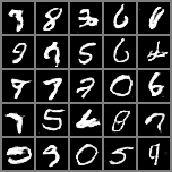

epoch: 7/300, batch: 210/600, G_loss: 2.1122825145721436, D_loss: (0.315781831741333, 0.19667452573776245)
epoch: 7/300, batch: 220/600, G_loss: 3.229512929916382, D_loss: (0.3682264983654022, 0.06551089137792587)
epoch: 7/300, batch: 230/600, G_loss: 4.0076069831848145, D_loss: (1.03914213180542, 0.026277752593159676)
epoch: 7/300, batch: 240/600, G_loss: 2.5381078720092773, D_loss: (0.4905640780925751, 0.11949317902326584)
epoch: 7/300, batch: 250/600, G_loss: 1.3133065700531006, D_loss: (0.03751353919506073, 0.44672489166259766)
epoch: 7/300, batch: 260/600, G_loss: 2.7701117992401123, D_loss: (0.27407029271125793, 0.10082486271858215)
epoch: 7/300, batch: 270/600, G_loss: 1.988283634185791, D_loss: (0.32180073857307434, 0.21832305192947388)
epoch: 7/300, batch: 280/600, G_loss: 0.44945335388183594, D_loss: (0.04562733694911003, 1.2419369220733643)
epoch: 7/300, batch: 290/600, G_loss: 1.2461960315704346, D_loss: (0.11079450696706772, 0.4704677164554596)
epoch: 7/300, batch: 300/600

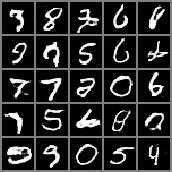

epoch: 7/300, batch: 310/600, G_loss: 2.0304105281829834, D_loss: (0.29723095893859863, 0.19999027252197266)
epoch: 7/300, batch: 320/600, G_loss: 3.618161916732788, D_loss: (0.8573856353759766, 0.052732404321432114)
epoch: 7/300, batch: 330/600, G_loss: 2.673600435256958, D_loss: (0.439598947763443, 0.11340193450450897)
epoch: 7/300, batch: 340/600, G_loss: 0.8153144717216492, D_loss: (0.08659542351961136, 0.8049457669258118)
epoch: 7/300, batch: 350/600, G_loss: 2.0473709106445312, D_loss: (0.17962190508842468, 0.2023952305316925)
epoch: 7/300, batch: 360/600, G_loss: 1.4485739469528198, D_loss: (0.14810022711753845, 0.37872692942619324)
epoch: 7/300, batch: 370/600, G_loss: 0.6420570611953735, D_loss: (0.05501333624124527, 1.0127360820770264)
epoch: 7/300, batch: 380/600, G_loss: 1.8975417613983154, D_loss: (0.24980300664901733, 0.22938570380210876)
epoch: 7/300, batch: 390/600, G_loss: 1.3120739459991455, D_loss: (0.20316210389137268, 0.42050087451934814)
epoch: 7/300, batch: 400/6

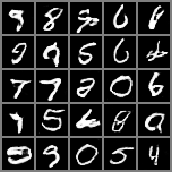

epoch: 7/300, batch: 410/600, G_loss: 1.9501932859420776, D_loss: (0.19635853171348572, 0.23492126166820526)
epoch: 7/300, batch: 420/600, G_loss: 3.726905107498169, D_loss: (1.109354019165039, 0.035392843186855316)
epoch: 7/300, batch: 430/600, G_loss: 2.384765863418579, D_loss: (0.1488477885723114, 0.14186491072177887)
epoch: 7/300, batch: 440/600, G_loss: 1.9398901462554932, D_loss: (0.3106437623500824, 0.23122362792491913)
epoch: 7/300, batch: 450/600, G_loss: 1.9582312107086182, D_loss: (0.317556768655777, 0.2410743087530136)
epoch: 7/300, batch: 460/600, G_loss: 2.3094232082366943, D_loss: (0.33669808506965637, 0.16650743782520294)
epoch: 7/300, batch: 470/600, G_loss: 3.853501319885254, D_loss: (1.063533902168274, 0.033903468400239944)
epoch: 7/300, batch: 480/600, G_loss: 3.0396735668182373, D_loss: (0.6006658673286438, 0.07137931138277054)
epoch: 7/300, batch: 490/600, G_loss: 0.7472596764564514, D_loss: (0.04875392094254494, 0.8332650661468506)
epoch: 7/300, batch: 500/600, G

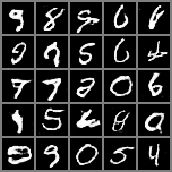

epoch: 7/300, batch: 510/600, G_loss: 2.0849170684814453, D_loss: (0.13044409453868866, 0.1981436312198639)
epoch: 7/300, batch: 520/600, G_loss: 0.694197416305542, D_loss: (0.03949884697794914, 0.9301602840423584)
epoch: 7/300, batch: 530/600, G_loss: 2.86561918258667, D_loss: (0.37192386388778687, 0.09008859843015671)
epoch: 7/300, batch: 540/600, G_loss: 2.0071980953216553, D_loss: (0.37570029497146606, 0.20681270956993103)
epoch: 7/300, batch: 550/600, G_loss: 1.9313420057296753, D_loss: (0.45422500371932983, 0.239327073097229)
epoch: 7/300, batch: 560/600, G_loss: 0.15559442341327667, D_loss: (0.006377989426255226, 2.2405242919921875)
epoch: 7/300, batch: 570/600, G_loss: 2.4092092514038086, D_loss: (0.3411085605621338, 0.15128791332244873)
epoch: 7/300, batch: 580/600, G_loss: 2.1517391204833984, D_loss: (0.20837251842021942, 0.1862957626581192)
epoch: 7/300, batch: 590/600, G_loss: 1.4185481071472168, D_loss: (0.11740484088659286, 0.392660915851593)
epoch: 8/300, batch: 0/600, G

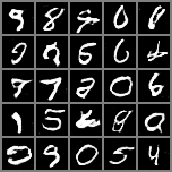

epoch: 8/300, batch: 10/600, G_loss: 2.104123592376709, D_loss: (0.4093291461467743, 0.17828981578350067)
epoch: 8/300, batch: 20/600, G_loss: 1.5456745624542236, D_loss: (0.15333902835845947, 0.39047133922576904)
epoch: 8/300, batch: 30/600, G_loss: 1.6588685512542725, D_loss: (0.1729739010334015, 0.2866092026233673)
epoch: 8/300, batch: 40/600, G_loss: 2.2368030548095703, D_loss: (0.10554786771535873, 0.16408897936344147)
epoch: 8/300, batch: 50/600, G_loss: 4.50063419342041, D_loss: (1.3280017375946045, 0.019797418266534805)
epoch: 8/300, batch: 60/600, G_loss: 0.8441972136497498, D_loss: (0.23890016973018646, 0.7570649981498718)
epoch: 8/300, batch: 70/600, G_loss: 1.8845579624176025, D_loss: (0.505759060382843, 0.22233079373836517)
epoch: 8/300, batch: 80/600, G_loss: 2.0669946670532227, D_loss: (0.2498684525489807, 0.18797343969345093)
epoch: 8/300, batch: 90/600, G_loss: 1.669142723083496, D_loss: (0.2609085142612457, 0.2917453646659851)
epoch: 8/300, batch: 100/600, G_loss: 1.6

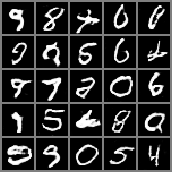

epoch: 8/300, batch: 110/600, G_loss: 0.5448856353759766, D_loss: (0.03639501705765724, 1.1806665658950806)
epoch: 8/300, batch: 120/600, G_loss: 2.511023759841919, D_loss: (0.34691372513771057, 0.13699613511562347)
epoch: 8/300, batch: 130/600, G_loss: 2.1313507556915283, D_loss: (0.3401046097278595, 0.20166398584842682)
epoch: 8/300, batch: 140/600, G_loss: 1.8042418956756592, D_loss: (0.14846321940422058, 0.2768329679965973)
epoch: 8/300, batch: 150/600, G_loss: 2.2944164276123047, D_loss: (0.3170472979545593, 0.1530149281024933)
epoch: 8/300, batch: 160/600, G_loss: 2.3192384243011475, D_loss: (0.3766006529331207, 0.1579720675945282)
epoch: 8/300, batch: 170/600, G_loss: 3.2795886993408203, D_loss: (0.5972849130630493, 0.059676188975572586)
epoch: 8/300, batch: 180/600, G_loss: 3.2457070350646973, D_loss: (0.4065600335597992, 0.06313862651586533)
epoch: 8/300, batch: 190/600, G_loss: 1.5338847637176514, D_loss: (0.10530093312263489, 0.33528023958206177)
epoch: 8/300, batch: 200/600

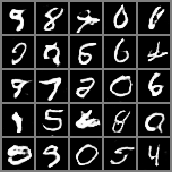

epoch: 8/300, batch: 210/600, G_loss: 4.523319244384766, D_loss: (1.0476016998291016, 0.021893290802836418)
epoch: 8/300, batch: 220/600, G_loss: 2.079023838043213, D_loss: (0.305829793214798, 0.18803727626800537)
epoch: 8/300, batch: 230/600, G_loss: 4.6120285987854, D_loss: (1.113339900970459, 0.01678323559463024)
epoch: 8/300, batch: 240/600, G_loss: 1.7403069734573364, D_loss: (0.10321369767189026, 0.29674360156059265)
epoch: 8/300, batch: 250/600, G_loss: 2.173896551132202, D_loss: (0.30362483859062195, 0.17010954022407532)
epoch: 8/300, batch: 260/600, G_loss: 2.639491081237793, D_loss: (0.23028557002544403, 0.111050084233284)
epoch: 8/300, batch: 270/600, G_loss: 0.7188848853111267, D_loss: (0.040775932371616364, 0.9388055205345154)
epoch: 8/300, batch: 280/600, G_loss: 1.026755928993225, D_loss: (0.17155182361602783, 0.6521332263946533)
epoch: 8/300, batch: 290/600, G_loss: 4.742478847503662, D_loss: (0.5012201070785522, 0.013207118958234787)
epoch: 8/300, batch: 300/600, G_los

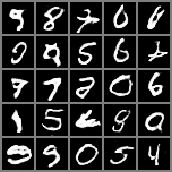

epoch: 8/300, batch: 310/600, G_loss: 0.9519044756889343, D_loss: (0.13089025020599365, 0.6595514416694641)
epoch: 8/300, batch: 320/600, G_loss: 1.2010700702667236, D_loss: (0.21168328821659088, 0.4834834933280945)
epoch: 8/300, batch: 330/600, G_loss: 1.9216876029968262, D_loss: (0.1883348673582077, 0.22968266904354095)
epoch: 8/300, batch: 340/600, G_loss: 1.802544355392456, D_loss: (0.17207713425159454, 0.26208803057670593)
epoch: 8/300, batch: 350/600, G_loss: 3.2111923694610596, D_loss: (0.7813817858695984, 0.07199974358081818)
epoch: 8/300, batch: 360/600, G_loss: 0.7961264848709106, D_loss: (0.038081344217061996, 0.8594151139259338)
epoch: 8/300, batch: 370/600, G_loss: 4.445387363433838, D_loss: (1.313725233078003, 0.02573353797197342)
epoch: 8/300, batch: 380/600, G_loss: 2.757344961166382, D_loss: (0.5823459625244141, 0.10382004827260971)
epoch: 8/300, batch: 390/600, G_loss: 2.30550217628479, D_loss: (0.4421935975551605, 0.16159546375274658)
epoch: 8/300, batch: 400/600, G_

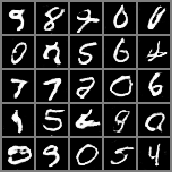

epoch: 8/300, batch: 410/600, G_loss: 0.9984287023544312, D_loss: (0.052790503948926926, 0.634688138961792)
epoch: 8/300, batch: 420/600, G_loss: 1.9118244647979736, D_loss: (0.18688571453094482, 0.2594965994358063)
epoch: 8/300, batch: 430/600, G_loss: 1.8595689535140991, D_loss: (0.4343677759170532, 0.2349085956811905)
epoch: 8/300, batch: 440/600, G_loss: 3.0257248878479004, D_loss: (0.5908601880073547, 0.07479065656661987)
epoch: 8/300, batch: 450/600, G_loss: 1.9624290466308594, D_loss: (0.21971391141414642, 0.22344788908958435)
epoch: 8/300, batch: 460/600, G_loss: 2.3876452445983887, D_loss: (0.34414422512054443, 0.16317743062973022)
epoch: 8/300, batch: 470/600, G_loss: 2.0339527130126953, D_loss: (0.27464526891708374, 0.20132394134998322)
epoch: 8/300, batch: 480/600, G_loss: 2.6665518283843994, D_loss: (0.40731537342071533, 0.10989604145288467)
epoch: 8/300, batch: 490/600, G_loss: 2.3373920917510986, D_loss: (0.27432259917259216, 0.15401135385036469)
epoch: 8/300, batch: 500

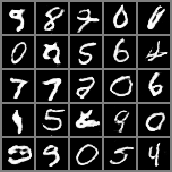

epoch: 8/300, batch: 510/600, G_loss: 1.441593050956726, D_loss: (0.09334298968315125, 0.3712524473667145)
epoch: 8/300, batch: 520/600, G_loss: 1.8210455179214478, D_loss: (0.1087263748049736, 0.2556452453136444)
epoch: 8/300, batch: 530/600, G_loss: 3.239924430847168, D_loss: (0.6940866112709045, 0.07264658808708191)
epoch: 8/300, batch: 540/600, G_loss: 1.8961492776870728, D_loss: (0.22016316652297974, 0.244170144200325)
epoch: 8/300, batch: 550/600, G_loss: 1.0809752941131592, D_loss: (0.0938481017947197, 0.5394904613494873)
epoch: 8/300, batch: 560/600, G_loss: 2.4585671424865723, D_loss: (0.1745859533548355, 0.16837415099143982)
epoch: 8/300, batch: 570/600, G_loss: 1.3242520093917847, D_loss: (0.04620986059308052, 0.43752413988113403)
epoch: 8/300, batch: 580/600, G_loss: 0.999285101890564, D_loss: (0.05219567194581032, 0.6796484589576721)
epoch: 8/300, batch: 590/600, G_loss: 1.6367295980453491, D_loss: (0.19504481554031372, 0.30431097745895386)
epoch: 9/300, batch: 0/600, G_lo

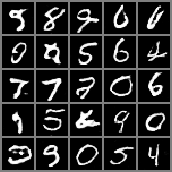

epoch: 9/300, batch: 10/600, G_loss: 3.114652395248413, D_loss: (0.11738830804824829, 0.06796038895845413)
epoch: 9/300, batch: 20/600, G_loss: 1.8304868936538696, D_loss: (0.3099517822265625, 0.2693547010421753)
epoch: 9/300, batch: 30/600, G_loss: 1.5977483987808228, D_loss: (0.1875586062669754, 0.2993396818637848)
epoch: 9/300, batch: 40/600, G_loss: 2.8775670528411865, D_loss: (0.3724041283130646, 0.09389593452215195)
epoch: 9/300, batch: 50/600, G_loss: 2.7103161811828613, D_loss: (0.380791574716568, 0.10494980961084366)
epoch: 9/300, batch: 60/600, G_loss: 1.6740566492080688, D_loss: (0.3002750277519226, 0.3094726502895355)
epoch: 9/300, batch: 70/600, G_loss: 4.06452751159668, D_loss: (1.0476406812667847, 0.02904157154262066)
epoch: 9/300, batch: 80/600, G_loss: 2.5346014499664307, D_loss: (0.34133121371269226, 0.13592803478240967)
epoch: 9/300, batch: 90/600, G_loss: 3.7443835735321045, D_loss: (0.7269023656845093, 0.0367196723818779)
epoch: 9/300, batch: 100/600, G_loss: 2.408

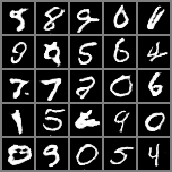

epoch: 9/300, batch: 110/600, G_loss: 1.3073006868362427, D_loss: (0.29656243324279785, 0.4986306130886078)
epoch: 9/300, batch: 120/600, G_loss: 2.2060787677764893, D_loss: (0.4208369851112366, 0.17839457094669342)
epoch: 9/300, batch: 130/600, G_loss: 1.7981674671173096, D_loss: (0.35330191254615784, 0.2554323077201843)
epoch: 9/300, batch: 140/600, G_loss: 1.1642906665802002, D_loss: (0.11625327914953232, 0.5406743884086609)
epoch: 9/300, batch: 150/600, G_loss: 2.625775098800659, D_loss: (0.33812034130096436, 0.12069927901029587)
epoch: 9/300, batch: 160/600, G_loss: 1.977286696434021, D_loss: (0.2062985748052597, 0.24223676323890686)
epoch: 9/300, batch: 170/600, G_loss: 2.4337821006774902, D_loss: (0.28216707706451416, 0.1406753659248352)
epoch: 9/300, batch: 180/600, G_loss: 2.5957376956939697, D_loss: (0.5657981038093567, 0.14097920060157776)
epoch: 9/300, batch: 190/600, G_loss: 2.2714121341705322, D_loss: (0.2903507351875305, 0.15490257740020752)
epoch: 9/300, batch: 200/600,

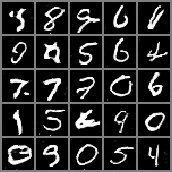

epoch: 9/300, batch: 210/600, G_loss: 3.1393935680389404, D_loss: (0.4357982575893402, 0.06768397986888885)
epoch: 9/300, batch: 220/600, G_loss: 3.509171724319458, D_loss: (0.3545253872871399, 0.04863229766488075)
epoch: 9/300, batch: 230/600, G_loss: 0.49370095133781433, D_loss: (0.011244001798331738, 1.192752480506897)
epoch: 9/300, batch: 240/600, G_loss: 2.8379690647125244, D_loss: (0.2951054871082306, 0.10913402587175369)
epoch: 9/300, batch: 250/600, G_loss: 1.6678162813186646, D_loss: (0.12450296431779861, 0.30730801820755005)
epoch: 9/300, batch: 260/600, G_loss: 1.0436633825302124, D_loss: (0.04051981121301651, 0.5792239904403687)
epoch: 9/300, batch: 270/600, G_loss: 0.9878016114234924, D_loss: (0.07154576480388641, 0.6794604659080505)
epoch: 9/300, batch: 280/600, G_loss: 2.056576728820801, D_loss: (0.28768277168273926, 0.218176931142807)
epoch: 9/300, batch: 290/600, G_loss: 2.2346396446228027, D_loss: (0.2626654803752899, 0.17504766583442688)
epoch: 9/300, batch: 300/600,

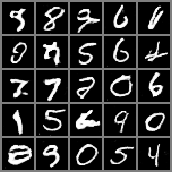

epoch: 9/300, batch: 310/600, G_loss: 1.570210576057434, D_loss: (0.14830264449119568, 0.3282454013824463)
epoch: 9/300, batch: 320/600, G_loss: 2.966681480407715, D_loss: (0.41588523983955383, 0.09502721577882767)
epoch: 9/300, batch: 330/600, G_loss: 1.2303680181503296, D_loss: (0.09892323613166809, 0.5199646949768066)
epoch: 9/300, batch: 340/600, G_loss: 1.4937628507614136, D_loss: (0.09255708009004593, 0.392342209815979)
epoch: 9/300, batch: 350/600, G_loss: 1.0975302457809448, D_loss: (0.2079107165336609, 0.5597876906394958)
epoch: 9/300, batch: 360/600, G_loss: 1.6705495119094849, D_loss: (0.16956429183483124, 0.29621052742004395)
epoch: 9/300, batch: 370/600, G_loss: 2.6547088623046875, D_loss: (0.49541908502578735, 0.1120549887418747)
epoch: 9/300, batch: 380/600, G_loss: 2.970548152923584, D_loss: (0.4183010160923004, 0.07731270045042038)
epoch: 9/300, batch: 390/600, G_loss: 2.5869250297546387, D_loss: (0.30978453159332275, 0.13008031249046326)
epoch: 9/300, batch: 400/600, 

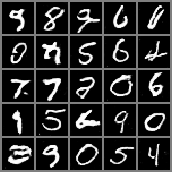

epoch: 9/300, batch: 410/600, G_loss: 3.969698905944824, D_loss: (0.6072271466255188, 0.03940289840102196)
epoch: 9/300, batch: 420/600, G_loss: 3.3716585636138916, D_loss: (0.5508289337158203, 0.05540823936462402)
epoch: 9/300, batch: 430/600, G_loss: 2.239797592163086, D_loss: (0.221512570977211, 0.17052622139453888)
epoch: 9/300, batch: 440/600, G_loss: 1.7351726293563843, D_loss: (0.06754014641046524, 0.2774002254009247)
epoch: 9/300, batch: 450/600, G_loss: 2.0077121257781982, D_loss: (0.15118542313575745, 0.21964216232299805)
epoch: 9/300, batch: 460/600, G_loss: 1.8516933917999268, D_loss: (0.12468656897544861, 0.29214972257614136)
epoch: 9/300, batch: 470/600, G_loss: 2.064589500427246, D_loss: (0.39001473784446716, 0.18864448368549347)
epoch: 9/300, batch: 480/600, G_loss: 2.3812053203582764, D_loss: (0.13396452367305756, 0.15658526122570038)
epoch: 9/300, batch: 490/600, G_loss: 3.4022600650787354, D_loss: (0.476156622171402, 0.05141632631421089)
epoch: 9/300, batch: 500/600,

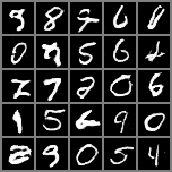

epoch: 9/300, batch: 510/600, G_loss: 4.342863082885742, D_loss: (0.6027104258537292, 0.02874540537595749)
epoch: 9/300, batch: 520/600, G_loss: 2.6489272117614746, D_loss: (0.46968212723731995, 0.11033028364181519)
epoch: 9/300, batch: 530/600, G_loss: 2.2748117446899414, D_loss: (0.09796235710382462, 0.16500911116600037)
epoch: 9/300, batch: 540/600, G_loss: 4.798700332641602, D_loss: (2.3081204891204834, 0.013323755003511906)
epoch: 9/300, batch: 550/600, G_loss: 2.1236279010772705, D_loss: (0.38457557559013367, 0.1778222918510437)
epoch: 9/300, batch: 560/600, G_loss: 1.8616795539855957, D_loss: (0.32353538274765015, 0.24432221055030823)
epoch: 9/300, batch: 570/600, G_loss: 2.1405014991760254, D_loss: (0.19769257307052612, 0.20144906640052795)
epoch: 9/300, batch: 580/600, G_loss: 2.5403881072998047, D_loss: (0.2881927192211151, 0.12475891411304474)
epoch: 9/300, batch: 590/600, G_loss: 2.1448285579681396, D_loss: (0.15205256640911102, 0.19402948021888733)
epoch: 10/300, batch: 0/

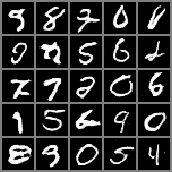

epoch: 10/300, batch: 10/600, G_loss: 2.71164608001709, D_loss: (0.3274151682853699, 0.11940717697143555)
epoch: 10/300, batch: 20/600, G_loss: 2.4738335609436035, D_loss: (0.5979434847831726, 0.13654889166355133)
epoch: 10/300, batch: 30/600, G_loss: 2.629988193511963, D_loss: (0.3580552339553833, 0.14107517898082733)
epoch: 10/300, batch: 40/600, G_loss: 2.489189863204956, D_loss: (0.13628610968589783, 0.13729137182235718)
epoch: 10/300, batch: 50/600, G_loss: 1.6941677331924438, D_loss: (0.10552963614463806, 0.3250555396080017)
epoch: 10/300, batch: 60/600, G_loss: 3.154977798461914, D_loss: (0.2386201024055481, 0.06953714042901993)
epoch: 10/300, batch: 70/600, G_loss: 3.690190076828003, D_loss: (1.0083633661270142, 0.04501613602042198)
epoch: 10/300, batch: 80/600, G_loss: 0.96785569190979, D_loss: (0.04234834760427475, 0.7234453558921814)
epoch: 10/300, batch: 90/600, G_loss: 1.0528450012207031, D_loss: (0.09757467359304428, 0.5969661474227905)
epoch: 10/300, batch: 100/600, G_lo

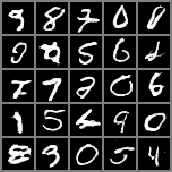

epoch: 10/300, batch: 110/600, G_loss: 2.094658613204956, D_loss: (0.2978358566761017, 0.19557280838489532)
epoch: 10/300, batch: 120/600, G_loss: 1.3242003917694092, D_loss: (0.031373947858810425, 0.4419407248497009)
epoch: 10/300, batch: 130/600, G_loss: 1.3910586833953857, D_loss: (0.16934072971343994, 0.39958441257476807)
epoch: 10/300, batch: 140/600, G_loss: 2.200289726257324, D_loss: (0.31303125619888306, 0.17511825263500214)
epoch: 10/300, batch: 150/600, G_loss: 1.7136180400848389, D_loss: (0.11407171934843063, 0.28509756922721863)
epoch: 10/300, batch: 160/600, G_loss: 2.186034679412842, D_loss: (0.17230083048343658, 0.2086988389492035)
epoch: 10/300, batch: 170/600, G_loss: 3.6694753170013428, D_loss: (0.6227179765701294, 0.04060062766075134)
epoch: 10/300, batch: 180/600, G_loss: 1.6378668546676636, D_loss: (0.08673949539661407, 0.33087441325187683)
epoch: 10/300, batch: 190/600, G_loss: 2.0955801010131836, D_loss: (0.4244944453239441, 0.21360419690608978)
epoch: 10/300, ba

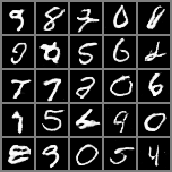

epoch: 10/300, batch: 210/600, G_loss: 1.711249828338623, D_loss: (0.12443569302558899, 0.3160611689090729)
epoch: 10/300, batch: 220/600, G_loss: 2.090144157409668, D_loss: (0.29459473490715027, 0.1851055771112442)
epoch: 10/300, batch: 230/600, G_loss: 2.0202486515045166, D_loss: (0.12867924571037292, 0.23013299703598022)
epoch: 10/300, batch: 240/600, G_loss: 1.9634917974472046, D_loss: (0.09910382330417633, 0.21856987476348877)
epoch: 10/300, batch: 250/600, G_loss: 2.728921890258789, D_loss: (0.2404191642999649, 0.11938745528459549)
epoch: 10/300, batch: 260/600, G_loss: 2.0215859413146973, D_loss: (0.21469907462596893, 0.22853995859622955)
epoch: 10/300, batch: 270/600, G_loss: 0.5396473407745361, D_loss: (0.01336020976305008, 1.2424432039260864)


In [0]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples,_) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
          
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val).data.cpu()
            display_batch_images(val_fake_samples)